In [35]:
# ✅ 0. CSV 로딩 및 전처리 (df_solar_final_sorted.csv 기반)
import pandas as pd
import numpy as np

# 필요한 열만 불러오기
usecols = [
    '발전구분', '설비용량(MW)', '연식(년)', 'year', 'month', 'day', 'hour',
    '기온(°C)', '풍속(m/s)', '풍향(16방위)', '하늘상태', '습도(%)', '강수량(mm)', '적설(cm)', '발전량(kWh)'
]
df = pd.read_csv("df_solar_final_sorted.csv", usecols=usecols)

# 발전소별로 그룹화
dynamic_x_list = []
static_x_list = []
labels_list = []

for plant, group in df.groupby('발전구분'):
    group = group.sort_values(by=['year', 'month', 'day', 'hour'])
    day_groups = group.groupby(['year', 'month', 'day'])
    for (y, m, d), day_data in day_groups:
        if len(day_data) != 24:
            continue
        day_data = day_data.sort_values('hour')
        dyn = day_data[['기온(°C)', '풍속(m/s)', '풍향(16방위)', '하늘상태', '습도(%)', '강수량(mm)', '적설(cm)']].values
        dynamic_x_list.append(dyn)
        static_x_list.append([day_data.iloc[0]['설비용량(MW)'], day_data.iloc[0]['연식(년)']])
        labels_list.append(day_data['발전량(kWh)'].values)

# numpy 배열로 변환
dynamic_x = np.stack(dynamic_x_list)
static_x = np.stack(static_x_list)
labels = np.stack(labels_list)

# ✅ NaN 제거
nan_mask_labels = ~np.isnan(labels).any(axis=1)
nan_mask_dynamic = ~np.isnan(dynamic_x).any(axis=(1, 2))
nan_mask_static = ~np.isnan(static_x).any(axis=1)
valid_mask = nan_mask_labels & nan_mask_dynamic & nan_mask_static

dynamic_x = dynamic_x[valid_mask]
static_x = static_x[valid_mask]
labels = labels[valid_mask]

In [37]:
# ✅ 1. 라이브러리 불러오기
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import random

# ✅ 시드 고정
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

# ✅ 2. Transformer 모델 정의
class SolarForecastTransformer(nn.Module):
    def __init__(self, input_dim, model_dim=128, num_heads=4, num_layers=2, dropout=0.1, output_dim=24):
        super(SolarForecastTransformer, self).__init__()
        self.input_projection = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.static_projection = nn.Linear(2, model_dim)
        self.output_layer = nn.Linear(model_dim, output_dim)

    def forward(self, dynamic_x, static_x):
        x = self.input_projection(dynamic_x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        static_emb = self.static_projection(static_x)
        fused = x + static_emb
        out = self.output_layer(fused)
        return out

# ✅ 3. Custom Dataset 정의
class SolarDataset(Dataset):
    def __init__(self, dynamic_x, static_x, y):
        self.dynamic_x = torch.tensor(dynamic_x, dtype=torch.float32)
        self.static_x = torch.tensor(static_x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.dynamic_x[idx], self.static_x[idx], self.y[idx]

# ✅ 4. 학습 및 평가 함수 정의

def train_model(model, dataloader, optimizer, criterion, epoch, total_epochs, repeat, total_repeats):
    model.train()
    total_loss = 0
    for i, (dynamic_x, static_x, y) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(dynamic_x, static_x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"[Repeat {repeat}/{total_repeats}] Epoch {epoch}/{total_epochs} - Loss: {total_loss / len(dataloader):.4f}")
    return total_loss / len(dataloader)

def evaluate_model(model, dataloader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for dynamic_x, static_x, y in dataloader:
            outputs = model(dynamic_x, static_x)
            preds.append(outputs.numpy())
            trues.append(y.numpy())
    preds = np.vstack(preds)
    trues = np.vstack(trues)
    mae = mean_absolute_error(trues, preds)
    rmse = mean_squared_error(trues, preds, squared=False)
    r2 = r2_score(trues, preds)
    return mae, rmse, r2, preds, trues

# ✅ 5. 학습 실행 함수

def run_experiment(dynamic_x, static_x, y):
    X_train, X_test, s_train, s_test, y_train, y_test = train_test_split(dynamic_x, static_x, y, test_size=0.2, random_state=42)
    train_dataset = SolarDataset(X_train, s_train, y_train)
    test_dataset = SolarDataset(X_test, s_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    best_rmse = float('inf')
    best_model = None
    best_config = None
    n_repeat = 3

    for repeat in range(1, n_repeat + 1):
        print(f"\n▶ Repeat {repeat}/{n_repeat} 시작")
        for model_dim in [64, 128]:
            for lr in [1e-3, 5e-4]:
                print(f"Training with model_dim={model_dim}, lr={lr}")
                model = SolarForecastTransformer(input_dim=X_train.shape[2], model_dim=model_dim)
                optimizer = optim.Adam(model.parameters(), lr=lr)
                criterion = nn.MSELoss()

                total_epochs = 10

                for epoch in range(1, total_epochs + 1):
                    loss = train_model(model, train_loader, optimizer, criterion, epoch, total_epochs, repeat, n_repeat)

                mae, rmse, r2, _, _ = evaluate_model(model, test_loader)
                print(f"Evaluation → MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = model
                    best_config = {'model_dim': model_dim, 'lr': lr}

    print("Best config:", best_config)
    return best_model, test_loader

# ✅ 6. 시각화 함수

def plot_sample_prediction(model, test_loader, index=0):
    model.eval()
    all_data = list(test_loader)
    dx, sx, y_true = all_data[index]
    with torch.no_grad():
        pred = model(dx, sx).numpy()
        true = y_true.numpy()
    plt.figure(figsize=(12, 4))
    plt.plot(true[0], label='Actual')
    plt.plot(pred[0], label='Predicted')
    plt.title(f"Sample {index} - 발전량 예측")
    plt.xlabel("Hour")
    plt.ylabel("kWh")
    plt.legend()
    plt.grid(True)
    plt.show()


▶ Repeat 1/3 시작
Training with model_dim=64, lr=0.001
[Repeat 1/3] Epoch 1/10 - Loss: 4096168.9756
[Repeat 1/3] Epoch 2/10 - Loss: 3821901.4135
[Repeat 1/3] Epoch 3/10 - Loss: 3391713.2755
[Repeat 1/3] Epoch 4/10 - Loss: 2927974.1482
[Repeat 1/3] Epoch 5/10 - Loss: 2516159.3483
[Repeat 1/3] Epoch 6/10 - Loss: 2203941.9089
[Repeat 1/3] Epoch 7/10 - Loss: 1990079.4386
[Repeat 1/3] Epoch 8/10 - Loss: 1822234.9943
[Repeat 1/3] Epoch 9/10 - Loss: 1708655.7660
[Repeat 1/3] Epoch 10/10 - Loss: 1590745.1185


c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Evaluation → MAE: 568.277, RMSE: 760.369, R²: 0.151
Training with model_dim=64, lr=0.0005
[Repeat 1/3] Epoch 1/10 - Loss: 4136320.4421
[Repeat 1/3] Epoch 2/10 - Loss: 4051285.5274
[Repeat 1/3] Epoch 3/10 - Loss: 3905875.7919
[Repeat 1/3] Epoch 4/10 - Loss: 3713032.1810
[Repeat 1/3] Epoch 5/10 - Loss: 3507846.2389
[Repeat 1/3] Epoch 6/10 - Loss: 3276045.3418
[Repeat 1/3] Epoch 7/10 - Loss: 3048450.1928
[Repeat 1/3] Epoch 8/10 - Loss: 2830328.2887
[Repeat 1/3] Epoch 9/10 - Loss: 2627761.9981
[Repeat 1/3] Epoch 10/10 - Loss: 2444677.4272


c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Evaluation → MAE: 575.265, RMSE: 921.518, R²: 0.052
Training with model_dim=128, lr=0.001
[Repeat 1/3] Epoch 1/10 - Loss: 4031567.9581
[Repeat 1/3] Epoch 2/10 - Loss: 3534360.5979
[Repeat 1/3] Epoch 3/10 - Loss: 2884669.6806
[Repeat 1/3] Epoch 4/10 - Loss: 2342588.1374
[Repeat 1/3] Epoch 5/10 - Loss: 2008269.6397
[Repeat 1/3] Epoch 6/10 - Loss: 1796121.4703
[Repeat 1/3] Epoch 7/10 - Loss: 1615812.5949
[Repeat 1/3] Epoch 8/10 - Loss: 1469466.4811
[Repeat 1/3] Epoch 9/10 - Loss: 1310843.4867
[Repeat 1/3] Epoch 10/10 - Loss: 1216098.1881


c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Evaluation → MAE: 458.342, RMSE: 666.608, R²: 0.213
Training with model_dim=128, lr=0.0005
[Repeat 1/3] Epoch 1/10 - Loss: 4112364.4108
[Repeat 1/3] Epoch 2/10 - Loss: 3922553.7687
[Repeat 1/3] Epoch 3/10 - Loss: 3652587.4375
[Repeat 1/3] Epoch 4/10 - Loss: 3339025.4954
[Repeat 1/3] Epoch 5/10 - Loss: 3014618.5774
[Repeat 1/3] Epoch 6/10 - Loss: 2711526.7146
[Repeat 1/3] Epoch 7/10 - Loss: 2459109.9322
[Repeat 1/3] Epoch 8/10 - Loss: 2243841.5846
[Repeat 1/3] Epoch 9/10 - Loss: 2082792.6662
[Repeat 1/3] Epoch 10/10 - Loss: 1953466.0549


c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Evaluation → MAE: 611.339, RMSE: 838.712, R²: 0.128

▶ Repeat 2/3 시작
Training with model_dim=64, lr=0.001
[Repeat 2/3] Epoch 1/10 - Loss: 4095174.8133
[Repeat 2/3] Epoch 2/10 - Loss: 3834769.2351
[Repeat 2/3] Epoch 3/10 - Loss: 3400295.0318
[Repeat 2/3] Epoch 4/10 - Loss: 2924317.5044
[Repeat 2/3] Epoch 5/10 - Loss: 2514385.5739
[Repeat 2/3] Epoch 6/10 - Loss: 2205269.6890
[Repeat 2/3] Epoch 7/10 - Loss: 1993140.4306
[Repeat 2/3] Epoch 8/10 - Loss: 1829242.5922
[Repeat 2/3] Epoch 9/10 - Loss: 1710588.2767
[Repeat 2/3] Epoch 10/10 - Loss: 1593052.1639


c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Evaluation → MAE: 558.911, RMSE: 757.512, R²: 0.182
Training with model_dim=64, lr=0.0005
[Repeat 2/3] Epoch 1/10 - Loss: 4131777.7294
[Repeat 2/3] Epoch 2/10 - Loss: 4037358.0015
[Repeat 2/3] Epoch 3/10 - Loss: 3889925.3255
[Repeat 2/3] Epoch 4/10 - Loss: 3713465.1402
[Repeat 2/3] Epoch 5/10 - Loss: 3491342.4446
[Repeat 2/3] Epoch 6/10 - Loss: 3265502.2138
[Repeat 2/3] Epoch 7/10 - Loss: 3040379.6199
[Repeat 2/3] Epoch 8/10 - Loss: 2826904.1018
[Repeat 2/3] Epoch 9/10 - Loss: 2625275.6364
[Repeat 2/3] Epoch 10/10 - Loss: 2445630.0133


c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Evaluation → MAE: 575.727, RMSE: 921.807, R²: 0.072
Training with model_dim=128, lr=0.001
[Repeat 2/3] Epoch 1/10 - Loss: 4028504.6189
[Repeat 2/3] Epoch 2/10 - Loss: 3538296.2694
[Repeat 2/3] Epoch 3/10 - Loss: 2864787.6582
[Repeat 2/3] Epoch 4/10 - Loss: 2318193.6315
[Repeat 2/3] Epoch 5/10 - Loss: 1968356.0812
[Repeat 2/3] Epoch 6/10 - Loss: 1756123.3304
[Repeat 2/3] Epoch 7/10 - Loss: 1592609.6946
[Repeat 2/3] Epoch 8/10 - Loss: 1434627.8868
[Repeat 2/3] Epoch 9/10 - Loss: 1295840.1210
[Repeat 2/3] Epoch 10/10 - Loss: 1179863.5490


c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Evaluation → MAE: 450.888, RMSE: 657.686, R²: 0.241
Training with model_dim=128, lr=0.0005
[Repeat 2/3] Epoch 1/10 - Loss: 4112497.2233
[Repeat 2/3] Epoch 2/10 - Loss: 3935729.4104
[Repeat 2/3] Epoch 3/10 - Loss: 3666082.4760
[Repeat 2/3] Epoch 4/10 - Loss: 3352505.8548
[Repeat 2/3] Epoch 5/10 - Loss: 3021658.5127
[Repeat 2/3] Epoch 6/10 - Loss: 2709498.6543
[Repeat 2/3] Epoch 7/10 - Loss: 2440374.5473
[Repeat 2/3] Epoch 8/10 - Loss: 2229705.3908
[Repeat 2/3] Epoch 9/10 - Loss: 2065974.5046
[Repeat 2/3] Epoch 10/10 - Loss: 1934694.3148


c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Evaluation → MAE: 609.901, RMSE: 833.775, R²: 0.118

▶ Repeat 3/3 시작
Training with model_dim=64, lr=0.001
[Repeat 3/3] Epoch 1/10 - Loss: 4093945.4253
[Repeat 3/3] Epoch 2/10 - Loss: 3818758.2809
[Repeat 3/3] Epoch 3/10 - Loss: 3376081.2149
[Repeat 3/3] Epoch 4/10 - Loss: 2893424.9889
[Repeat 3/3] Epoch 5/10 - Loss: 2472606.7199
[Repeat 3/3] Epoch 6/10 - Loss: 2151786.7725
[Repeat 3/3] Epoch 7/10 - Loss: 1936804.1288
[Repeat 3/3] Epoch 8/10 - Loss: 1782879.5240
[Repeat 3/3] Epoch 9/10 - Loss: 1661839.1086
[Repeat 3/3] Epoch 10/10 - Loss: 1543956.8615


c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Evaluation → MAE: 534.572, RMSE: 744.827, R²: 0.177
Training with model_dim=64, lr=0.0005
[Repeat 3/3] Epoch 1/10 - Loss: 4140837.5282
[Repeat 3/3] Epoch 2/10 - Loss: 4062666.1658
[Repeat 3/3] Epoch 3/10 - Loss: 3916588.4615
[Repeat 3/3] Epoch 4/10 - Loss: 3727763.0911
[Repeat 3/3] Epoch 5/10 - Loss: 3515846.1947
[Repeat 3/3] Epoch 6/10 - Loss: 3293195.7671
[Repeat 3/3] Epoch 7/10 - Loss: 3053528.9184
[Repeat 3/3] Epoch 8/10 - Loss: 2836766.7046
[Repeat 3/3] Epoch 9/10 - Loss: 2638225.3545
[Repeat 3/3] Epoch 10/10 - Loss: 2459254.6490


c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Evaluation → MAE: 573.652, RMSE: 922.181, R²: 0.063
Training with model_dim=128, lr=0.001
[Repeat 3/3] Epoch 1/10 - Loss: 4028653.9522
[Repeat 3/3] Epoch 2/10 - Loss: 3524537.5084
[Repeat 3/3] Epoch 3/10 - Loss: 2865094.8079
[Repeat 3/3] Epoch 4/10 - Loss: 2306645.6875
[Repeat 3/3] Epoch 5/10 - Loss: 1961646.5995
[Repeat 3/3] Epoch 6/10 - Loss: 1745842.2637
[Repeat 3/3] Epoch 7/10 - Loss: 1583157.0238
[Repeat 3/3] Epoch 8/10 - Loss: 1420748.3508
[Repeat 3/3] Epoch 9/10 - Loss: 1283692.7729
[Repeat 3/3] Epoch 10/10 - Loss: 1173797.1763


c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Evaluation → MAE: 452.519, RMSE: 657.101, R²: 0.241
Training with model_dim=128, lr=0.0005
[Repeat 3/3] Epoch 1/10 - Loss: 4108515.3426
[Repeat 3/3] Epoch 2/10 - Loss: 3921090.6875
[Repeat 3/3] Epoch 3/10 - Loss: 3663076.4162
[Repeat 3/3] Epoch 4/10 - Loss: 3336647.4089
[Repeat 3/3] Epoch 5/10 - Loss: 3015138.2809
[Repeat 3/3] Epoch 6/10 - Loss: 2700652.6559
[Repeat 3/3] Epoch 7/10 - Loss: 2431663.2363
[Repeat 3/3] Epoch 8/10 - Loss: 2216736.2967
[Repeat 3/3] Epoch 9/10 - Loss: 2052370.0816
[Repeat 3/3] Epoch 10/10 - Loss: 1927148.5701


c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48156 (\N{HANGUL SYLLABLE BAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\anaconda3\Li

Evaluation → MAE: 603.427, RMSE: 830.742, R²: 0.122
Best config: {'model_dim': 128, 'lr': 0.001}


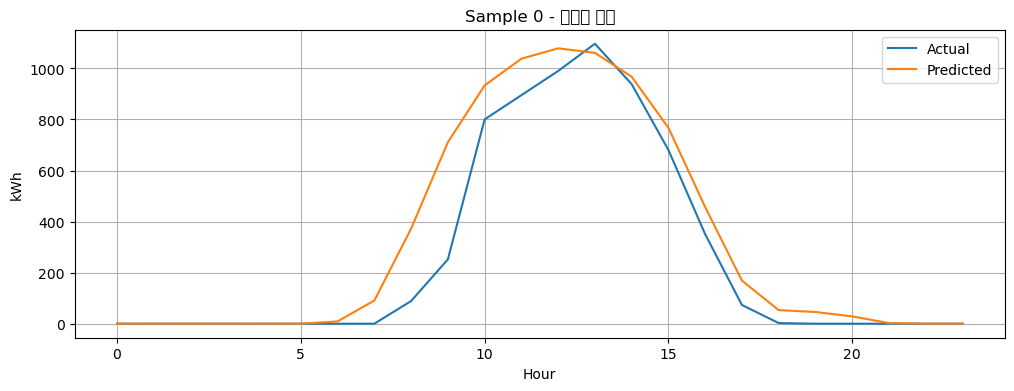

In [38]:
# ✅ 7. 학습 실행 및 예측 시각화
final_model, test_loader = run_experiment(dynamic_x, static_x, labels)
plot_sample_prediction(final_model, test_loader, index=0)